In [ ]:
# импорт библиотек
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import catboost as catb

In [66]:
# чтение данных
df = pd.read_csv('whole_data.csv')

# удаление колонок
delcols = [
    'type',
    # 'Bmag',
    # 'gpmag', # высокая корреляция
    # 'rpmag', # высокая корреляция
    # 'ipmag', # высокая корреляция
    # 'err',
    # 'nobs',
    'e_ipmag',
    'e_Vmag',
    'e_rpmag',
    'e_gpmag',
    'e_Bmag'
]
data = df.drop(columns=delcols)

# удаление NaN-ов и подготовка данных
data = data.dropna().reset_index(drop=True)
present = data['present']
data = data.drop(columns='present')

In [67]:
# стандатизируем признаки
scaler = StandardScaler()
newdata = pd.DataFrame(data = scaler.fit_transform(data),
 columns = data.columns)

In [68]:
# разделение выборки на тренировочную и тестовую
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(newdata, present, train_size=0.8)

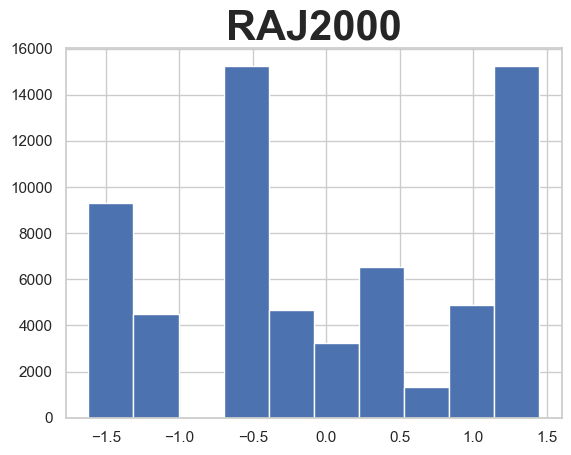

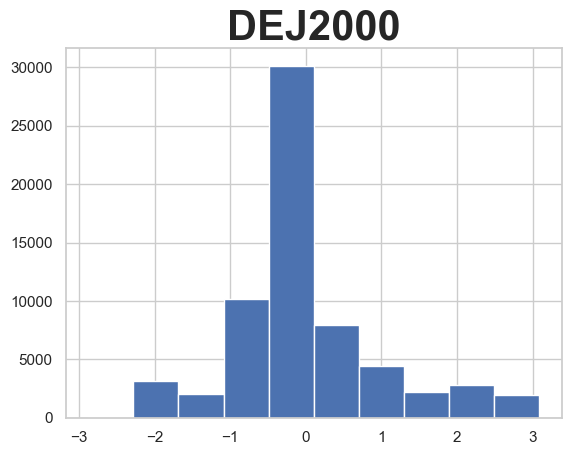

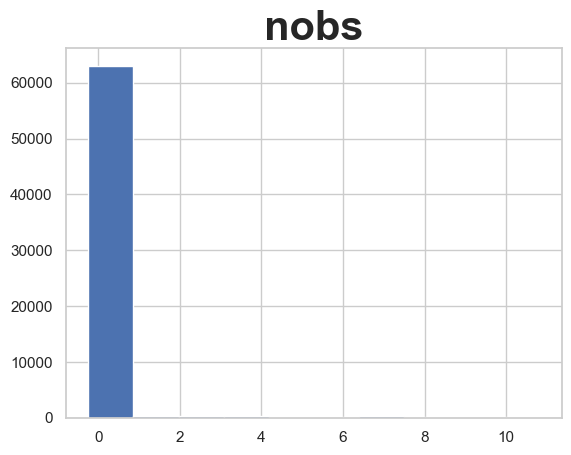

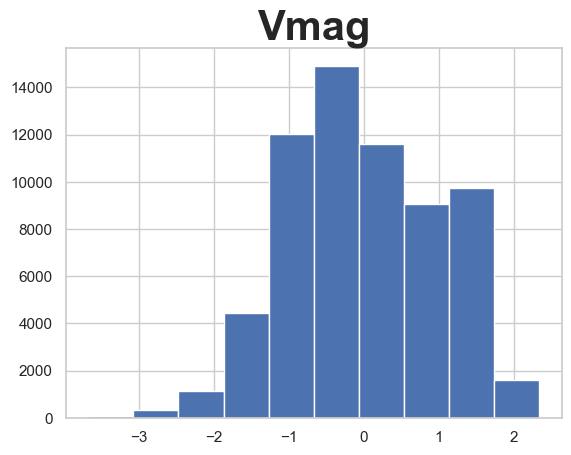

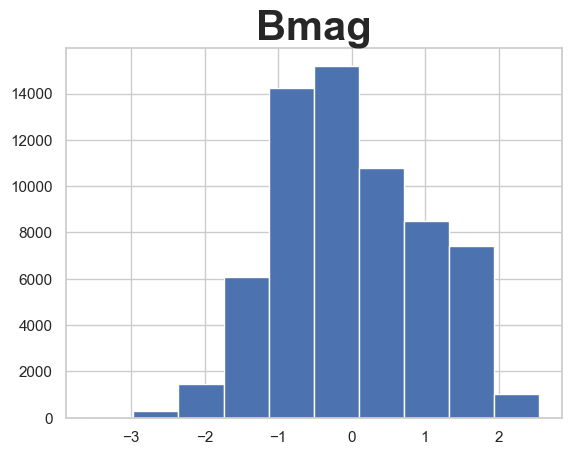

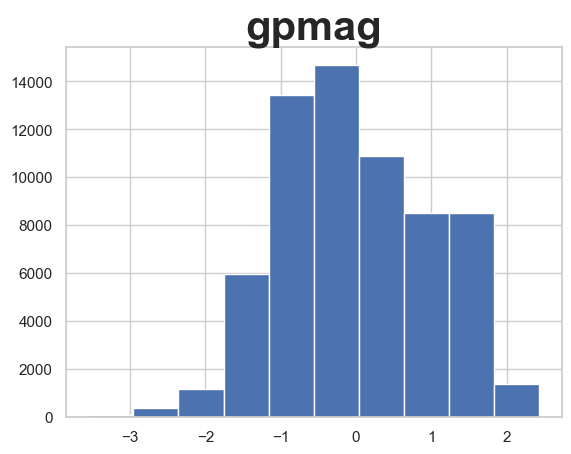

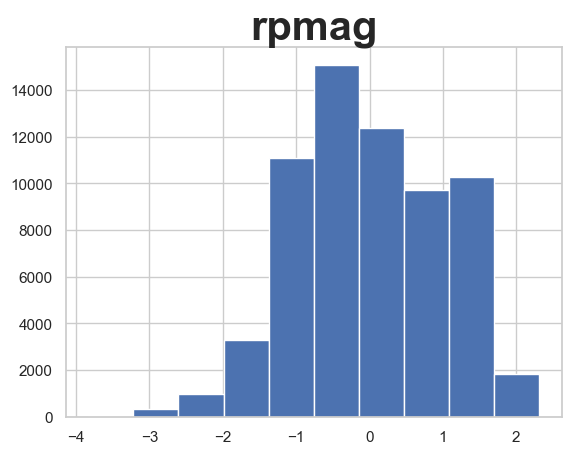

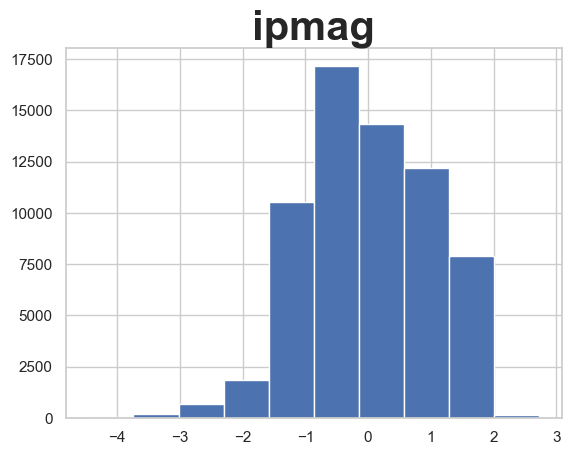

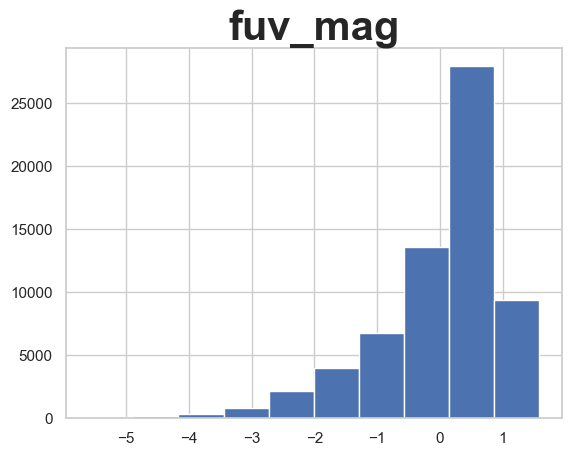

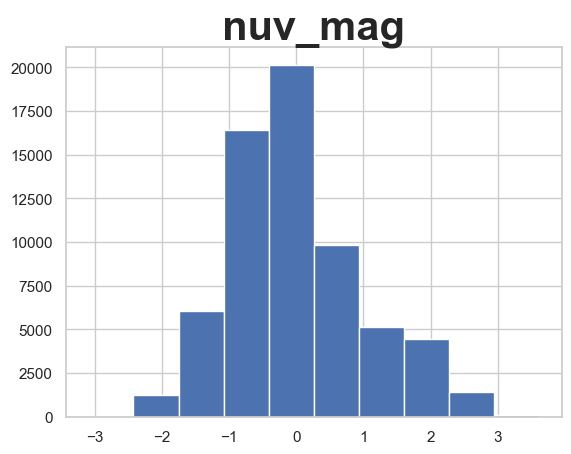

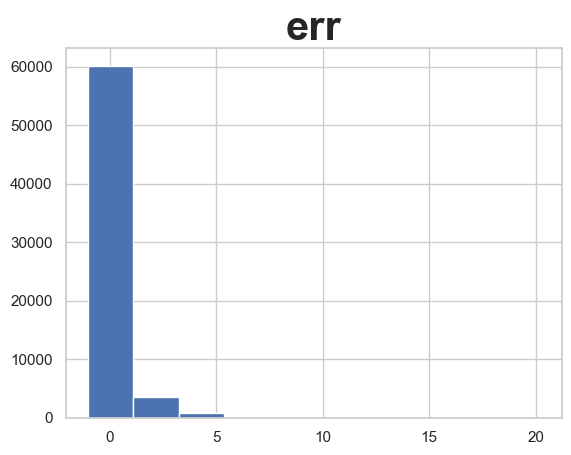

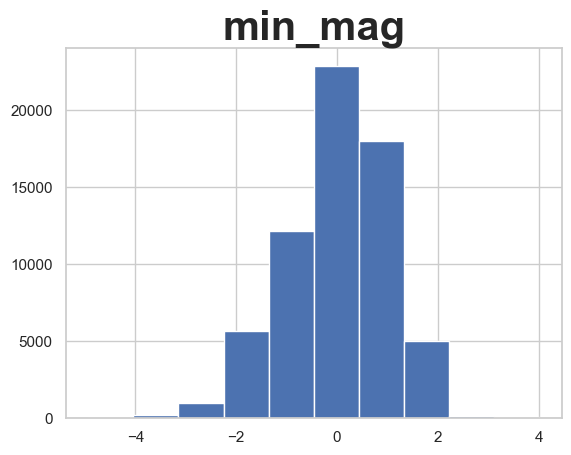

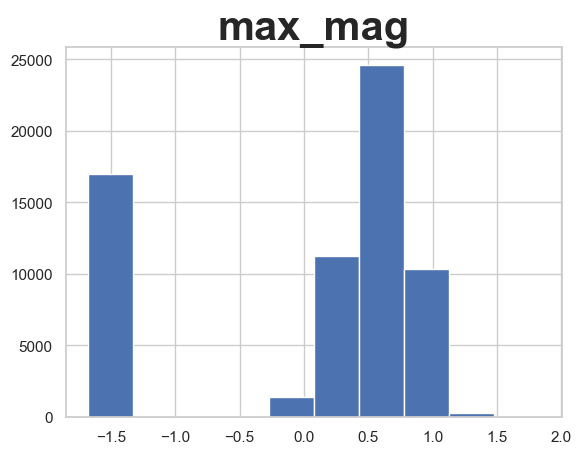

In [69]:
# функция построения однотиптых графиков распределения
def plot_graph_distribution(string, data):
    sns.set(style='whitegrid')
    plt.title(label = string, size=30, weight='bold')
    plt.hist(data, bins=10)
    plt.show()

# вывод распределений
for i in newdata:
    plot_graph_distribution(i, newdata[i])

In [70]:
# тренировка модели
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

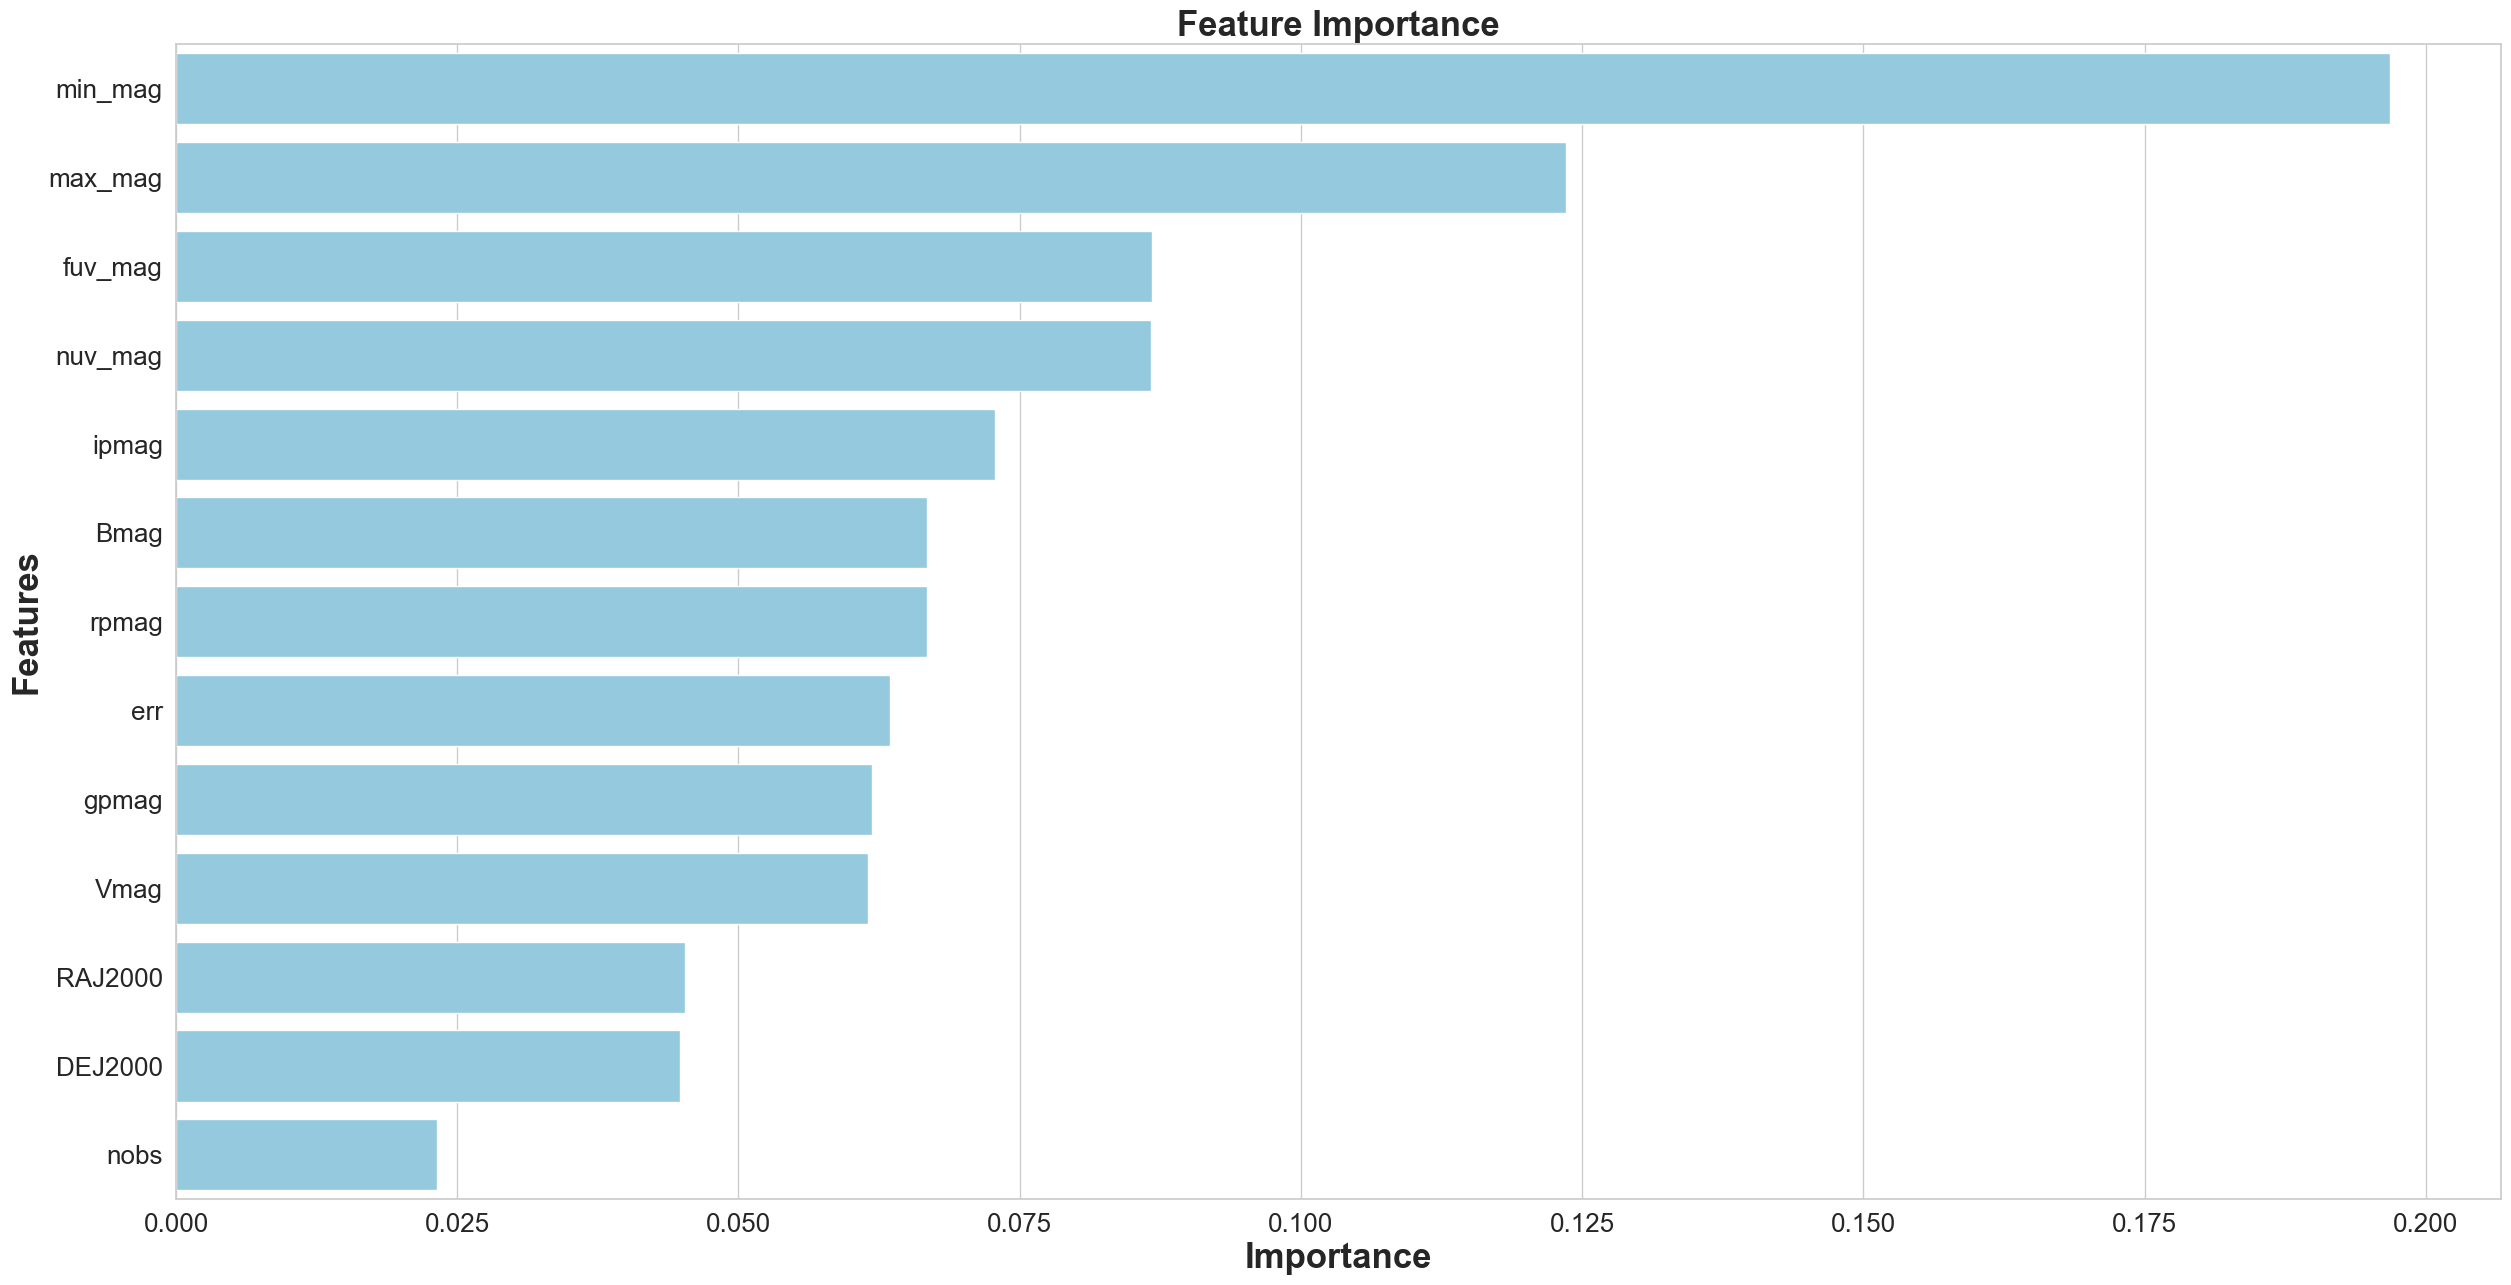

In [71]:
# смотрим важность каждой колонки
feats = {}
for feature, importance in zip(newdata.columns, classifier.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

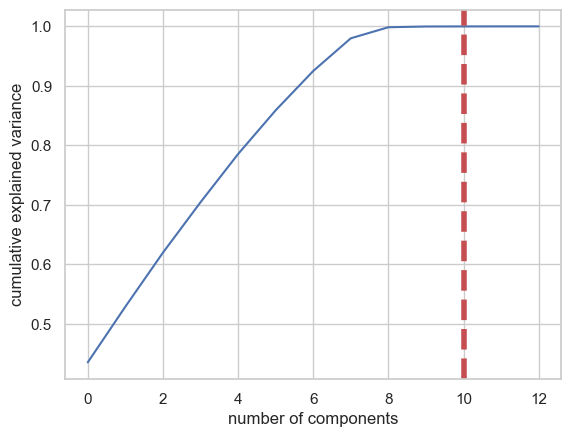

In [72]:
# сколько компонент можно оставить
pca_test = PCA(n_components=13)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
plt.show()

In [9]:
# уменьшаем кол-во измерений
# pca = PCA(n_components=11)
# pca.fit(X_train)
# X_train_pca = pca.transform(X_train)
# X_test_pca = pca.transform(X_test)
X_train_pca = X_train
X_test_pca = X_test

In [10]:
# перебираем параметры в поисках лучшей модели
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 800, num = 6)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 20, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 20, stop = 30, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)] + [int(x) for x in np.linspace(start = 15, stop = 25, num = 5)]
bootstrap = [False, True]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(classifier, 
                        param_dist, 
                        n_iter = 50,
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_pca, y_train)

# вывод лучших параметров (не всегда оптимально)
rs.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 500,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 18,
 'bootstrap': False}

In [11]:
# табличка с десятью лучшими моделями
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,500,20,1,sqrt,18,False,0.936561,1
1,800,20,5,log2,18,False,0.935888,2
2,560,21,3,sqrt,18,False,0.935772,3
3,800,22,2,sqrt,16,False,0.934176,4
4,680,27,4,sqrt,17,False,0.933926,5
5,500,24,3,sqrt,15,False,0.932772,6
6,500,26,1,log2,15,False,0.932695,7
7,500,26,4,log2,15,False,0.931829,8
8,560,25,5,log2,20,True,0.931521,9
9,680,20,5,sqrt,17,True,0.931271,10


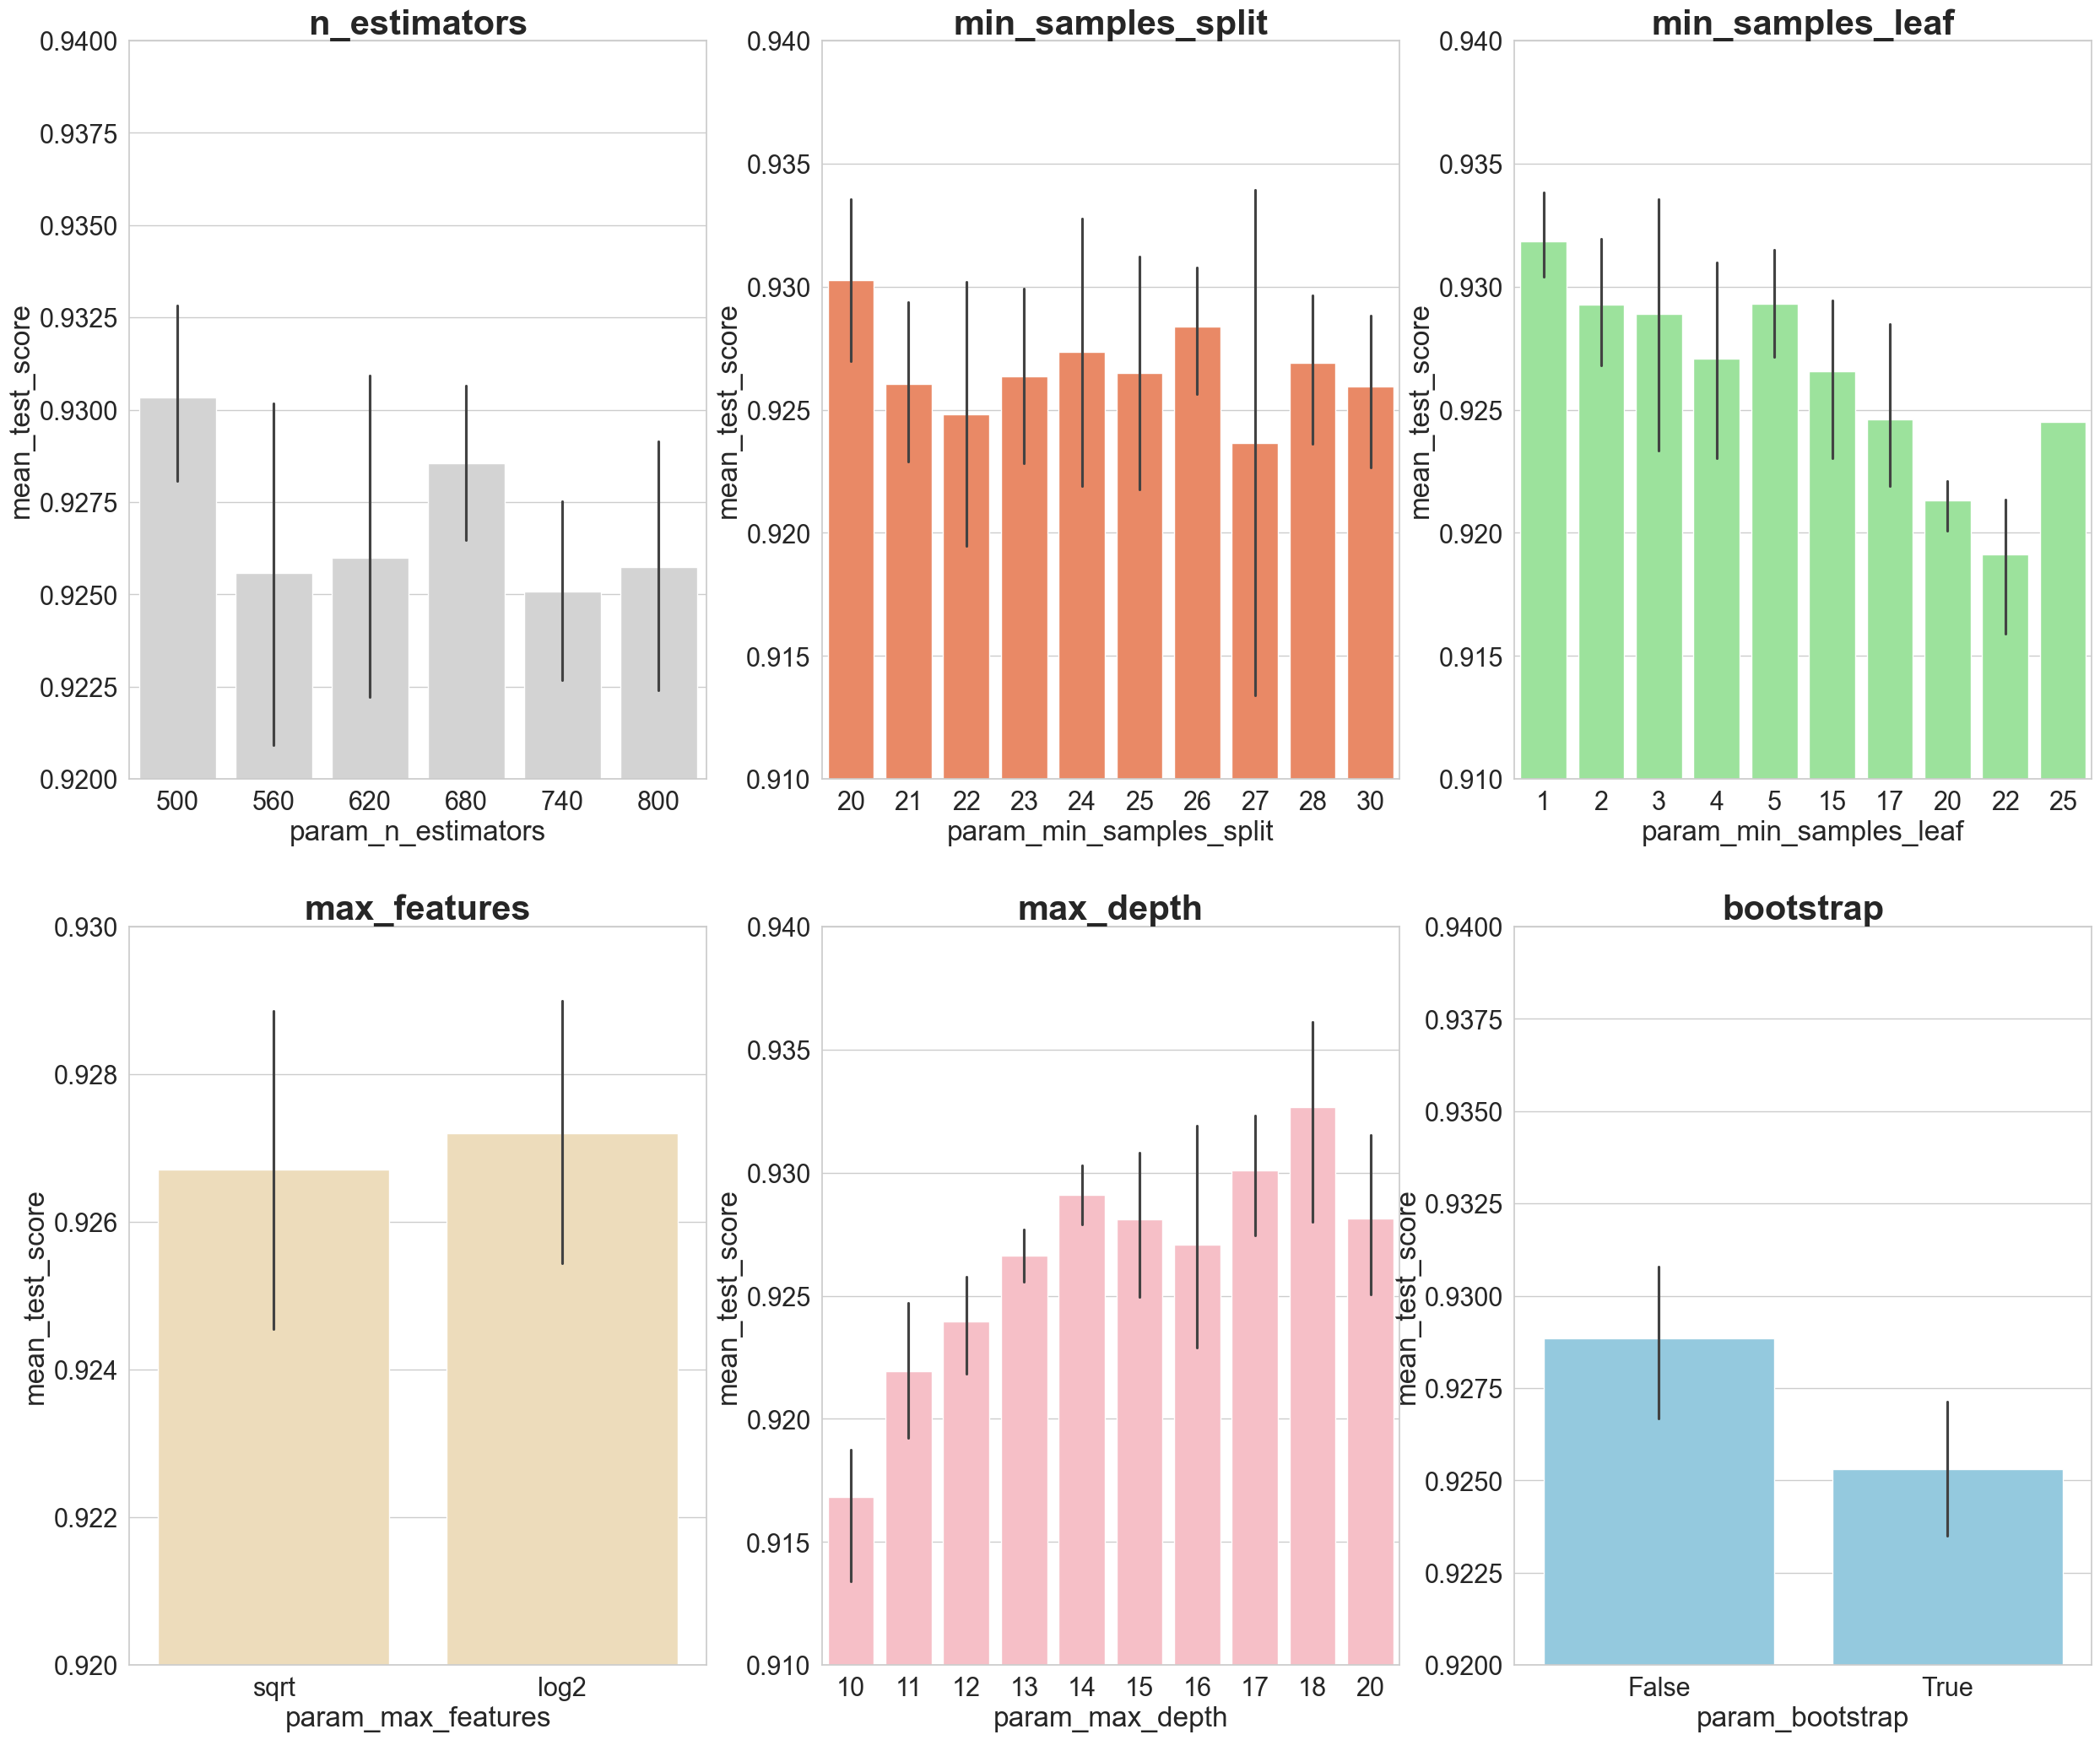

In [20]:
# функция построения однотипных графиков параметров
def plot_graph_params(axs, data, pos, color, label, ylim, x_text):
    sns.barplot(x=x_text, y='mean_test_score', data=rs_df, ax=axs[pos], color=color)
    axs[pos].set_ylim(ylim)
    axs[pos].set_title(label = label, size=30, weight='bold')

# смотрим лучшие параметры
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
plot_graph_params(axs, rs_df, (0, 0), 'lightgrey', 'n_estimators', (.92, .94), 'param_n_estimators')
plot_graph_params(axs, rs_df, (0, 1), 'coral', 'min_samples_split', (.91, .94), 'param_min_samples_split')
plot_graph_params(axs, rs_df, (0, 2), 'lightgreen', 'min_samples_leaf', (.91, .94), 'param_min_samples_leaf')
plot_graph_params(axs, rs_df, (1, 0), 'wheat', 'max_features', (.92, .93), 'param_max_features')
plot_graph_params(axs, rs_df, (1, 1), 'lightpink', 'max_depth', (.91, .94), 'param_max_depth')
plot_graph_params(axs, rs_df, (1, 2), 'skyblue', 'bootstrap', (.92, .94), 'param_bootstrap')
plt.show()

In [34]:
# функция для отображения метрик
def display_metrics(y_test, res):
    print('F1 score:', sk.metrics.f1_score(y_test, res))
    print('ROC AUC:', sk.metrics.roc_auc_score(y_test, res))
    print(sk.metrics.classification_report(y_test, res))

In [36]:
# тренировка модели
classifier.fit(X_train_pca, y_train)

# проверка метриками f1 и roc auc
res = classifier.predict(X_test_pca)
display_metrics(y_test, res)

F1 score: 0.6599726152441807
ROC AUC: 0.7655669921957963
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11665
           1       0.84      0.54      0.66      1332

    accuracy                           0.94     12997
   macro avg       0.90      0.77      0.81     12997
weighted avg       0.94      0.94      0.94     12997



In [35]:
res = rs.best_estimator_.predict(X_test_pca)
display_metrics(y_test, res)

F1 score: 0.6283846872082166
ROC AUC: 0.7467553601608466
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11665
           1       0.83      0.51      0.63      1332

    accuracy                           0.94     12997
   macro avg       0.89      0.75      0.80     12997
weighted avg       0.93      0.94      0.93     12997



In [41]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300, 400, 500]
max_features = ['log2']
max_depth = [18, 19]
min_samples_split = [19, 20, 27]
min_samples_leaf = [1, 3]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(classifier, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

In [42]:
res = rfc_3.predict(X_test_pca)
display_metrics(y_test, res)

F1 score: 0.6341236634123664
ROC AUC: 0.7501337385392249
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11665
           1       0.83      0.51      0.63      1332

    accuracy                           0.94     12997
   macro avg       0.89      0.75      0.80     12997
weighted avg       0.93      0.94      0.93     12997



In [44]:
catclassifier = catb.CatBoostClassifier(logging_level='Silent')
catclassifier.fit(X_train_pca, y_train)

res = catclassifier.predict(X_test_pca)
display_metrics(y_test, res)

F1 score: 0.755159854309996
ROC AUC: 0.8413953923919633
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     11665
           1       0.82      0.70      0.76      1332

    accuracy                           0.95     12997
   macro avg       0.89      0.84      0.86     12997
weighted avg       0.95      0.95      0.95     12997



In [45]:
gradclassifier = sk.ensemble.GradientBoostingClassifier()
gradclassifier.fit(X_train_pca, y_train)
res = gradclassifier.predict(X_test_pca)
display_metrics(y_test, res)

F1 score: 0.17269076305220885
ROC AUC: 0.5470089356394543
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11665
           1       0.80      0.10      0.17      1332

    accuracy                           0.90     12997
   macro avg       0.85      0.55      0.56     12997
weighted avg       0.90      0.90      0.87     12997



In [50]:
dtrain = xgb.DMatrix(X_train_pca, label=y_train)
dtest = xgb.DMatrix(X_test_pca, label=y_test)
params = {'objective': 'multi:softmax', 'num_class': 2}
xgbclassifier = xgb.train(params, dtrain)
res = xgbclassifier.predict(dtest)
display_metrics(y_test, res)

F1 score: 0.26600372902423863
ROC AUC: 0.5776299445609347
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11665
           1       0.77      0.16      0.27      1332

    accuracy                           0.91     12997
   macro avg       0.84      0.58      0.61     12997
weighted avg       0.90      0.91      0.88     12997

